In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('src/')

from ssd import SSD
from encoder import DataEncoder

In [3]:
net = SSD()
data_encoder = DataEncoder()
net.load_state_dict(torch.load('pretrained.pth'))
net.eval();

In [4]:
img_original = cv2.imread('images/dogs-and-cats.jpg', cv2.IMREAD_COLOR)

In [5]:
%%time
img = cv2.resize(
    img_original, (300, 300), interpolation=cv2.INTER_LINEAR
).astype('float32')
img = img - np.array([104.0, 117.0, 123.0], 'float32')
img = torch.FloatTensor(img.transpose((2, 0, 1)))
img = Variable(img.unsqueeze(0), volatile=True)

loc, conf = net(img)

loc = loc.squeeze(0).data
conf = F.softmax(conf.squeeze(0)).data

boxes, labels, scores = data_encoder.decode(loc, conf)

CPU times: user 7.75 s, sys: 188 ms, total: 7.94 s
Wall time: 2.08 s


In [6]:
VOC_LABELS = [
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

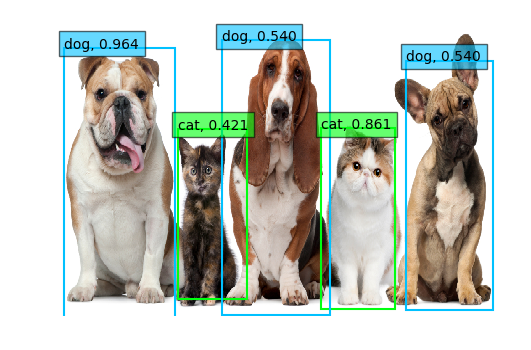

In [7]:
fig, ax = plt.subplots(1, dpi=100)
ax.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)/255.0, aspect='auto')

for box, label, score in zip(boxes, labels, scores):
    x0, y0, x1, y1 = box
    height, width = img_original.shape[:2]
    x0, x1 = x0*width, x1*width
    y0, y1 = y0*height, y1*height
    
    w, h = x1 - x0, y1 - y0
    color = colors[label - 1]
    label = VOC_LABELS[label - 1]
    
    rect = plt.Rectangle(
        (x0, y0), w, h, 
        linewidth=1.5, edgecolor=color, facecolor='none'
    )
    ax.add_patch(rect)
    text = label + ', {:.3f}'.format(score)
    ax.text(x0, y0, text, bbox={'facecolor': color, 'alpha': 0.6})

plt.axis('off');